In [51]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/ahmad/projects/utils/')
from custom_widgets import Browser

In [53]:
colormap = cv2.COLORMAP_BONE
browser = Browser(parent_path='/data_sp/intercam/drd_behavior')
browser.show()

### read a frame - binary stop bit is determined based on the acquisition resolution via the set presest


In [54]:
# pick a random frame from the .dat
filepath = browser.path_textbox.value
if 'flir' in filepath.lower():
    preset = 'flir'
elif 'lucid' in filepath.lower():
    preset = 'lucid'
else:
    raise Exception("cannot understand preset from filename")
    
    
    ######################
    ## HELPER FUNCTIONS ##
    ######################

def readbinary(filepath, start=100, length=None, preset=preset, pick_random=False):
    if length is None:
        if preset=='lucid':
            # multiply by 2 to accomodate the factt that we save distance data at 16bit
            shape = [640, 480]
            length = np.prod(shape) * 2
            dtype = np.uint16
        elif preset=='flir':
            shape = [720, 540]
            length= np.prod(shape)
            dtype = np.uint8

    with open(filepath, 'rb') as file:
        file.seek(start*length)  # Move the pointer
        segment = file.read(length)  # Read the specfied length
    return segment, shape, dtype

def intensity_to_rgba(frame, minval=452, maxval=3065, colormap=cv2.COLORMAP_TURBO):
    new_frame = np.ones((frame.shape[0], frame.shape[1], 4))
    disp_frame = frame.copy().astype("float")
    disp_frame -= minval
    disp_frame[disp_frame < 0] = 0
    disp_frame /= np.abs(maxval - minval)
    disp_frame[disp_frame >= 1] = 1
    disp_frame *= 255
    bgr_frame = cv2.applyColorMap(disp_frame.astype(np.uint8), colormap)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    new_frame[:, :, :3] = rgb_frame
    new_frame = new_frame.astype(np.uint8)
    return new_frame

def sort_rectangle_points(points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)

    # Calculate the angles of each point relative to the centroid
    angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    
    # Sort the points based on the angles
    sorted_indices = np.argsort(angles)
    
    return points[sorted_indices]
def crop_aligned_rectangle(image, points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Find the bounding box of the points
    rect = cv2.boundingRect(points[:4])
    x, y, w, h = rect

    # Get the transformation matrix for the perspective transform
    dst_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(points, dst_pts)

    # Apply the perspective transformation to the image
    warped = cv2.warpPerspective(image, M, (w, h))

    return warped

def stack2mp4(rawfiledir, points, dims, fps=30, colormap=cv2.COLORMAP_INFERNO, minval=None, maxval=None):
    """
    Convert a sequence of images into an MP4 video.
    
    Args:
    - image_files (list): List of file paths to the input images.
    - output_video_path (str): Path to save the output video.
    - fps (int): Frames per second of the output video.
    """

    if preset == 'flir':
        minval=50
        maxval = 255
        dims = [720, 540]
        # dims = [360, 540]
        dtype = np.uint8
        length = np.prod(dims)

    if preset == 'lucid':
        minval = 900
        maxval=2300
        dims=[640, 480]
        dtype = np.uint16
        length = np.prod(dims) * 2

    stemname = Path(rawfiledir).stem
    output_dir = Path(rawfiledir).parent.joinpath(f'{stemname}_warped.avi').as_posix()
    
    # get first image
    print(f'determining dimensions')
    with open(filepath, 'rb') as file:
        file.seek(0)  # Move the pointer
        buffer = file.read(length)  # Read the specfied length
        buffer = np.frombuffer(buffer, dtype=dtype)
        # im3 is the frame reshaped to the correct shape
        buffer = buffer.reshape(dims[::-1])

        tempx = buffer
        tempx = crop_aligned_rectangle(tempx, points)
        dimx = tempx.shape
        cropped_dims = dimx[:2][::-1]
        print(f'cropped dimensions: {cropped_dims}')
        # Move the cursor to the end of the file
        file.seek(0, os.SEEK_END)
        file_size = file.tell()
        approx_num_frames = file_size//length
        
    print(f'saving to {output_dir}')
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_dir, fourcc, fps, cropped_dims, isColor=True)

    with open(filepath, 'rb') as file:
        try:
            for i in tqdm (range(approx_num_frames)):
                file.seek(i*length)
                buffer = file.read(length)  # Read the specfied length
                buffer = np.frombuffer(buffer, dtype=dtype)
                # im3 is the frame reshaped to the correct shape
                buffer = buffer.reshape(dims[::-1])
                img = intensity_to_rgba(buffer, minval=minval, maxval=maxval, colormap=colormap)[:,:,:3]
                img = crop_aligned_rectangle(img[..., [2, 1, 0]], points)
                # img = intensity_to_rgba(img, minval=img.min(), maxval=img.max(), colormap=colormap)[:,:,:3] 
                out.write(img)

        except Exception as e:
            print(e)
            out.release()


# def raw2mp4(rawfiledir, points, dims = [640, 480], fps=30, minval=900, maxval=3065, dtype=np.uint8, colormap=cv2.COLORMAP_INFERNO, preset = None, till=None):
    
#     if preset == 'flir':
#         minval=50
#         maxval = 255
#         dims = [720, 540]
#         # dims = [360, 540]
#         colormap=cv2.COLORMAP_TURBO
#         dtype = np.uint8

#     if preset == 'lucid':
#         minval = 900
#         maxval=2300
#         dims=[640, 480]
#         dtype = np.uint16
#         colormap=cv2.COLORMAP_TURBO

#     stemname = Path(rawfiledir).stem
#     output_dir = Path(rawfiledir).parent.joinpath(f'{stemname}_warped.avi').as_posix()

#     # get images
#     depth_data = np.fromfile(rawfiledir, dtype=dtype)
#     depth_data =  depth_data.reshape([-1, *dims[::-1]])
#     a = input(f"found {depth_data.shape[0]} frames. Continue? (y/n): ")
#     if a == 'y':
#         if till is None:
#             stack2mp4(imgs=depth_data, points=points, output_video_path=output_dir, fps=fps,dims=dims, minval=minval, maxval=maxval, colormap = colormap)
#         else:
#             stack2mp4(imgs=depth_data[:till,:,:], points=points, output_video_path=output_dir, fps=fps,dims=dims, minval=minval, maxval=maxval, colormap = colormap)   
#     else:
#         pass


In [55]:
# im is the binary data of the first frame, read based on the preset (flir or lucid) acquisition resolution
im, shape, dtype = readbinary(filepath)
# im2 is the frame in the correct dtype
im2 = np.frombuffer(im, dtype=dtype)
# im3 is the frame reshaped to the correct shape
im3 = im2.reshape(shape[::-1])


##############################
# ignore - for interactivity #
##############################
if preset == 'lucid':
    slider_values = {'minval': 900, 'maxval': 2300}
else:
    slider_values = {'minval': 0, 'maxval': 115}
def display_frame(minval, maxval, colormap=cv2.COLORMAP_TURBO):
    bar = im3
    slider_values['minval'] = minval
    slider_values['maxval'] = maxval
    foo = intensity_to_rgba(bar, minval=minval, maxval=maxval, colormap=colormap)
    plt.imshow(foo[:,:,:3])
    plt.show()


### view frame - according to set colormap - set the min and max values

In [56]:
%matplotlib inline
plt.close('all')

from ipywidgets import interactive
frame_plot = interactive(display_frame, minval=slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)
output = frame_plot.children[-1]
output.layout.height = '450px'
frame_plot

interactive(children=(IntSlider(value=0, description='minval', max=1), IntSlider(value=115, description='maxva…

### cropping: select 4 points to warp and crop

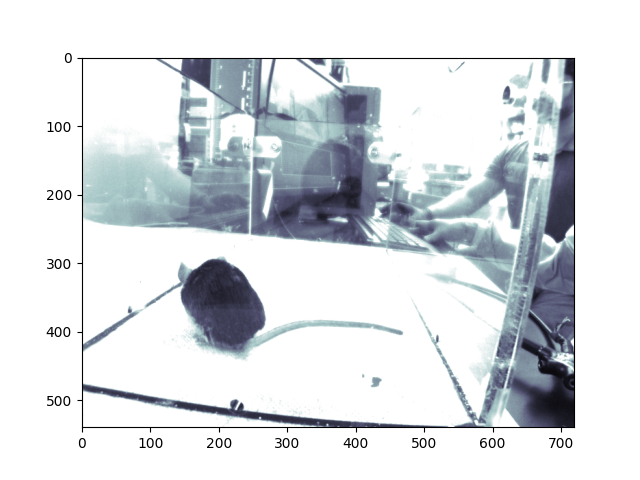

In [57]:
%matplotlib widget
im4 = intensity_to_rgba(im3, minval = slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)[:,:,:3]
fig, ax = plt.subplots()
ax.imshow(im4)
points = []

def onclick(event):
    if event.inaxes:
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'ro')
        fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()



### show

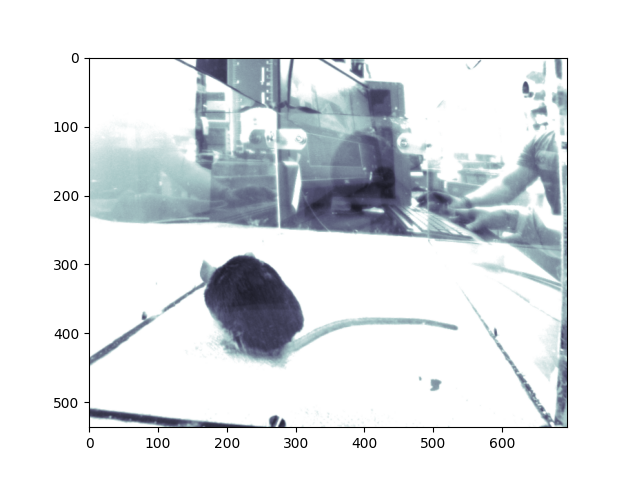

In [58]:
sorted_points = sort_rectangle_points(np.array(points))
warped_cropped = crop_aligned_rectangle(im4, points = sorted_points)

plt.figure()
plt.imshow(warped_cropped, cmap='turbo')
plt.show()

In [59]:
stack2mp4(filepath, sorted_points, dims=shape, fps=30, colormap=colormap, minval=slider_values['minval'], maxval=slider_values['maxval'])

determining dimensions
cropped dimensions: (695, 537)
saving to /data_sp/intercam/drd_behavior/m41(0)/none/none/drd_behavior_m41(0)_none_none_v2_300_300_12_20240424090035-845374/FLIR-1E10011883A9-011883A9_warped.avi


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18019/18019 [05:18<00:00, 56.56it/s]


In [ ]:
# import cv2
# import numpy as np
# from pathlib import Path

# colormap=cv2.COLORMAP_BONE

# raw2mp4(filepath, sorted_points, dims=shape, minval=slider_values['minval'], maxval=slider_values['maxval'], dtype=dtype, colormap=colormap, till=100)

In [35]:
im4.shape

(480, 640, 3)

In [37]:
crop_aligned_rectangle(im4, sorted_points).shape

(250, 422, 3)